In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from PIL import Image

from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import joblib
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import albumentations
import cv2

import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [3]:
transfrom=transforms.Compose([transforms.Resize(224),
                        transforms.CenterCrop(224),
                             transforms.ToTensor()])

In [4]:
#https://debuggercafe.com/creating-efficient-image-data-loaders-in-pytorch-for-deep-learning/

In [5]:
class ImageDataset(Dataset):
    
    def __init__(self, path, labels, tfms=None):
        # data loading
        self.X = path
        self.y = labels
        
    def __getitem__(self, index):
        # dataset[0]
        image = Image.open(self.X[index]).convert('RGB')
        image = transfrom(image)
        #image = np.transpose(image, (2, 0, 1))
        type(image)
        label = self.y[index]
        return image, torch.tensor(label, dtype=torch.long)
        
    def __len__(self):
        # len(dataset)
        return(len(self.X))
    

In [6]:
df = pd.read_csv('../input/data.csv')
X_ = df.image_path.values
y_ = df.target.values

In [7]:
#(xtrain, xtest, ytrain, ytest) = (train_test_split(X_, y_,test_size=0.25, random_state=42))


In [8]:
train_data = ImageDataset(X_, y_, 0)

In [9]:
train_data = torch.utils.data.DataLoader(train_data, batch_size=100)

In [10]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [11]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [12]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [14]:
b1 = nn.Sequential(
    nn.Conv2d(3, 224, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(224), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [15]:
num_channels, growth_rate = 224, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [18]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 2))

In [19]:
def train(net, train_iter, num_epochs, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
           torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
         for i ,(X, y) in enumerate(train_data):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

In [21]:
divice =torch.device("cuda")
lr, num_epochs, batch_size = 0.1, 10, 256
train(net, train_data, num_epochs, lr)
torch.save(net.state_dict(), 'mlp.params')

training on cuda


In [17]:
def create_confusion_matrix(y_true, y_predicted):
    return confusion_matrix(y_true, y_predicted)

In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.get_cmap('Blues')): 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(ticks=range(cm.min(), cm.max() + 1))

    target_names = ['0', '1']
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [19]:
train_data = ImageDataset(X_, y_, 0)
train_data = torch.utils.data.DataLoader(train_data)

In [20]:
#X = []
#y = []
net.to('cpu')
y_true = []
y_predicted = []
softmax = nn.Softmax(dim=1)
for (image, label) in train_data:
    y_true.append(label.detach())
    y_predicted_tensor = net(image)
    y_predicted_tensor = softmax(y_predicted_tensor)
    y_predicted.append(torch.max(y_predicted_tensor).detach())

[tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([1])]
[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.),

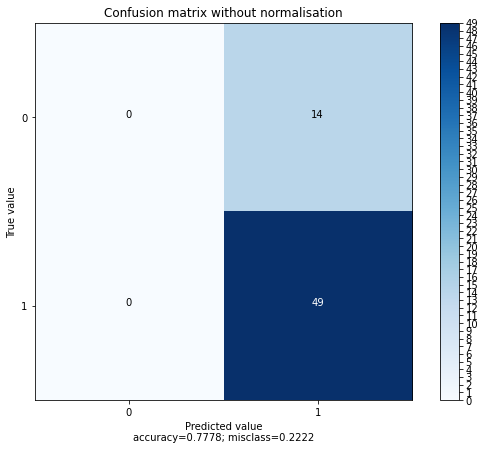

In [21]:
cm = create_confusion_matrix(y_true, y_predicted)
plot_confusion_matrix(cm, 'Confusion matrix without normalisation')

In [30]:
dataiter = iter(train_data)
images, labels = dataiter.next()


In [31]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/old_text_image_experiment_1')


In [35]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


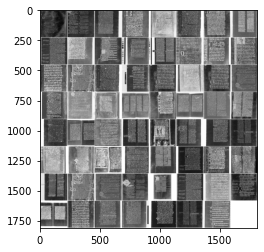

In [36]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('old_text_image_images', img_grid)

In [37]:
net.to('cpu')
writer.add_graph(net, images)

TypeError: select_n_random() missing 1 required positional argument: 'labels'